# Speed Dating Experiment

In this project, we use KNN and Decision Tree to predict whether one person is going to date the other again or not.

The data are from kaggle [Speed Dating Experiement](https://www.kaggle.com/annavictoria/speed-dating-experiment)


## Table of Content
- [Setup](#setup)
- [Initial Data Processing](#initial)
- [Algorithm Implementation](#algorithm)
    - [KNN](#knn)
        - [Self Implement](#selfknn)
        - [Scikit Learn](#skknn)
    - [Decision Tree](#dt)
        - [Self Implement](#selfdt)
        - [Scikit Leran](#skdt)
- [Choosing Predcit Target](#target)
- [Other Training Method Implementaions](#trainmethod)

## Contributors
- [Hao-Tzu Huang](https://github.com/nacat)
- [Wei Lee](https://github.com/Lee-W)

---

# <a name='setup'></a> Setup

In [1]:
import math
from copy import deepcopy
from collections import Counter, Iterable
from io import StringIO
from operator import itemgetter, attrgetter
from functools import partial
import random
import time

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from sklearn import tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
from sklearn.metrics import accuracy_score

import pydot_ng as pydot
from IPython.display import Image, display
from tabulate import tabulate

from bokeh.io import show, output_notebook
from bokeh.plotting import figure

output_notebook()

Loading BokehJS ...

# <a name='initial'></a>Initial Data Processing

## Load Data

In [2]:
df = pd.read_csv('speed-dating-experiment/Speed Dating Data.csv', encoding="ISO-8859-1")

## Analyze Data

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8378 entries, 0 to 8377
Columns: 195 entries, iid to amb5_3
dtypes: float64(174), int64(13), object(8)
memory usage: 12.5+ MB


Number of rows (participants): 8377.  
Number of columns (features): 195.

In [4]:
# Unparseable columns

unparseable_cols = df.select_dtypes(include=['object']).columns
unparseable_cols

Index(['field', 'undergra', 'mn_sat', 'tuition', 'from', 'zipcode', 'income',
       'career'],
      dtype='object')

The columns above cannot be parsed to numbers directly.

## Data Cleaning

The unparseable columns are handled as following

### `income, zipcode, tuition, mn_sat`
These columns contain commas and can be parsed to numbers after cleaning

In [5]:
# Clean Comma
COLUMNS_WITH_COMMA = ['income', 'zipcode', 'tuition', 'mn_sat']

for col in COLUMNS_WITH_COMMA:
    df[col] = df[col].replace('[,]', '', regex=True).astype(float)

### `career, field`
They have already been encoded in other columns (i.e. career_c, field_cd)  
Thus, we simple drop them.

In [6]:
ENCODED_STRING_COLUMNS = ['career', 'field']
df.drop(ENCODED_STRING_COLUMNS, axis=1, inplace=True)

## `undergra, from`
These two columns are pure strings.  
The content diversity is too high to encode them like `career` and `field`.  
Thus, we use `same_from` and `same_undergra` instead.  
The two values indicate that if the values of `undergra` and `from` are the same between the participant and his or her partner.  
If so, the value would be 1.  
Otherwise, it would be 0.

Then, the `undergra` and `from` are dropped.

In [7]:
OTHER_STRING_COLUMNS = ['undergra', 'from']

# Joined df based on partner
joined_df = df.merge(
    df,
    how='left',
    left_on=['iid', 'id', 'pid', 'partner'],
    right_on=['pid', 'partner', 'iid', 'id']
)

In [8]:
df['same_from'] = joined_df['from_x'] == joined_df['from_y']
df['same_undergra'] = joined_df['undergra_x'] == joined_df['undergra_y']
df.drop(OTHER_STRING_COLUMNS, axis=1, inplace=True)

---

# <a name='algorithm'></a> Algorithm Implementation

## <a name='knn'></a> KNN

### <a name='selfknn'></a> Self Implement

In [14]:
def to_tuple(v):
    if isinstance(v, Iterable): 
        v = (v, )
    return v

In [15]:
def eucldn_similarity(v1, v2):
    """
    Euclidean Distance。越相似，距離越近，相似度數值會越小。
    :param v1:
    :param v2:
    :return: 1/distance(v1,v2) 取距離的倒數，越大越像
    """
    distance = np.sqrt(np.sum(np.power(v1-v2, 2)))
    return 1 / distance

In [16]:
def cos_similarity(v1, v2):
    """
    Cosine（兩向量的餘弦）。越相似，夾角越小，相似度數值會越高。
    :param v1:
    :param v2:
    :return: cos(v1,v2)介於1到-1之間 越大越像
    """          
    son = np.sum(np.multiply(v1,v2))
    mom = np.sqrt(np.sum(np.power(v1, 2) * np.sum(np.power(v2, 2))))
    cosin = son / mom
    return cosin

In [17]:
def knn_prediction(nb_list):
    cnt = Counter(target for (sim, target) in nb_list)
    label = cnt.most_common(1)[0][0]
    return label

In [18]:
def knn_classify(test_X, train_X, train_y, k=5):
    nb = []
    for feature, label in zip(train_X, train_y):
        nb.append((cos_similarity(test_X,feature),to_tuple(label)))

    nb.sort(reverse=True)
    label = knn_prediction(nb[:k])
    return label

In [75]:
def knn(train_X, test_X, train_y, test_y, n_neighbors=5):
    count = 0
    for feature, label in zip(test_X, test_y):
        pred_y = knn_classify(feature, train_X, train_y, n_neighbors)
        if pred_y == to_tuple(label):
            count += 1
    accuracy = count / len(test_X)
    return accuracy

## <a name='skknn'></a> Scikit Learn

In [20]:
def knn_with_sklearn(train_X, test_X, train_y, test_y,
                     **kwargs):
    clf = KNeighborsClassifier(**kwargs)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    return accuracy_score(pred, test_y)

# <a name='dt'></a> Decision Tree

## <a name='selfdt'></a> Self Implement

In [21]:
def gini_index(lcnt, rcnt):
    gini = 0.0
    tcnt = lcnt + rcnt
    tl = sum(lcnt.values())
    tr = sum(rcnt.values())
    tt = tl + tr
    l = 0.0
    r = 0.0
    for class_label in set(tcnt):
        if tl is not 0:
            l += pow(lcnt[class_label]/tl,2)
        if tr is not 0:    
            r += pow(rcnt[class_label]/tr,2)
    if tt is not 0:
        gini = (tl/tt)*(1-l)+(tr/tt)*(1-r)
    return gini

In [22]:
def try_split(train_X, train_y, index, value):
    gini = 1.0
    left_X, right_X = list(), list()
    left_y, right_y = list(), list()
    lcnt, rcnt, tcnt = Counter(), Counter(), Counter
    for row_X, row_y in zip(train_X, train_y):
        if row_X[index] < value:
            left_X.append(row_X)
            left_y.append(row_y)
            lcnt[to_tuple(row_y)] += 1
        else:
            right_X.append(row_X)
            right_y.append(row_y)
            rcnt[to_tuple(row_y)] += 1
    if not left_X:
        l = 0
    else:
        l = lcnt.most_common(1)[0][0]
    if not right_X:
        r = 0
    else:
        r = rcnt.most_common(1)[0][0]
    gini = gini_index(lcnt, rcnt)
    return gini, left_X, right_X, left_y, right_y, l, r

In [23]:
def determine_split(train_X, train_y):
    calculated = set()
    b_feature, b_value, b_gini, b_group = 999, 999, 999, None
    for index in range(len(train_X[0])):
        for tp in train_X:
            if tp[index] not in calculated:
                calculated.add(tp[index])
                gini, left_group, right_group, left_label, right_label, l, r= try_split(train_X, train_y, index, tp[index])
                groups = left_group, right_group
                labels = left_label, right_label
                counter = l, r
                if gini < b_gini:
                    b_index, b_value, b_gini, b_group, b_label, b_cnt= index, tp[index], gini, groups, labels, counter
                if gini == 0.0:
                    break
    return {'index':b_index, 'value':b_value, 'gini':b_gini, 'groups':b_group, 'labels':b_label, 'count':b_cnt}

In [24]:
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    l_label, r_label = node['labels']
    l_cnt, r_cnt = node['count']
    #del(node['groups'])
    #del(node['labels'])

    if not left or not right:
        if isinstance(l_cnt, tuple):
            node['left'] = node['right'] = l_cnt
        elif isinstance(r_cnt, tuple):
            node['left'] = node['right'] = r_cnt
        else:
            node['left'] = node['right'] = None
        #node['left'] = node['right'] = countLabel(l_label+r_label)
        return
    if depth >= max_depth:
        node['left'], node['right'] = l_cnt, r_cnt#countLabel(l_label), countLabel(r_label)
        return
    if len(left) <= min_size:
        node['left'] = l_cnt#countLabel(l_label)
    else:
        node['left'] = determine_split(left, l_label)
        split(node['left'], max_depth, min_size, depth+1)
    if len(right) <= min_size:
        node['right'] = r_cnt#countLabel(r_label)
    else:
        node['right'] = determine_split(right, r_label)
        split(node['right'], max_depth, min_size, depth+1)

In [25]:
def build_tree(train_X, train_y, max_depth, min_size):
    root = determine_split(train_X, train_y)
    split(root, max_depth, min_size, 1)
    return root

In [26]:
def print_tree(node, depth=0):
    if isinstance(node, dict):
        print('%s[X%d < %.3f]' % ((depth*' ', (node['index']+1), node['value'])))
        print_tree(node['left'], depth+1)
        print_tree(node['right'], depth+1)
    else:
        print('%s[%s]' % ((depth*' ', node)))

In [27]:
def dt_predict(tp, node):
    if tp[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return dt_predict(tp, node['left'])
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return dt_predict(tp, node['right'])
        else:
            return node['right']

In [28]:
def dt_accuracy(test_X, test_y, tree):
    accuracy = 0
    count = 0
    for tp, label in zip(test_X, test_y):
        pred = dt_predict(tp, tree)
        if pred == to_tuple(label):
            count += 1
    accuracy = count/len(test_y)
    return accuracy

In [29]:
def dt(train_X, test_X, train_y, test_y, max_depth=5, min_samples_leaf=5):
    accuracy = 0
    tree = build_tree(train_X, train_y, max_depth, min_samples_leaf)
    #print_tree(tree)
    accuracy = dt_accuracy(test_X, test_y, tree)
    return accuracy

## <a name='skdt'></a> Scikit Learn

In [30]:
def dt_with_sklearn(train_X, test_X, train_y, test_y,
                    feature_names=None, visualize=False, **kwargs):
    if 'random_state' not in kwargs:
        kwargs['random_state'] = 1
        
    clf = tree.DecisionTreeClassifier(**kwargs)
    clf.fit(train_X, train_y)
    pred = clf.predict(test_X)
    if visualize:
        visualize_dt(clf, feature_names)
    return accuracy_score(pred, test_y)

In [31]:
# Visualize Decision Tree

def visualize_dt(clf, feature_names=None):
    dot_data = StringIO()
    tree.export_graphviz(clf, out_file=dot_data,
                         class_names=True, feature_names=feature_names)
    graph = pydot.graph_from_dot_data(dot_data.getvalue())  
    display(Image(graph.create_png()))

---

# <a name='target'></a> Choosing Predict Target

Initial we choose the column `match` as predict target.  

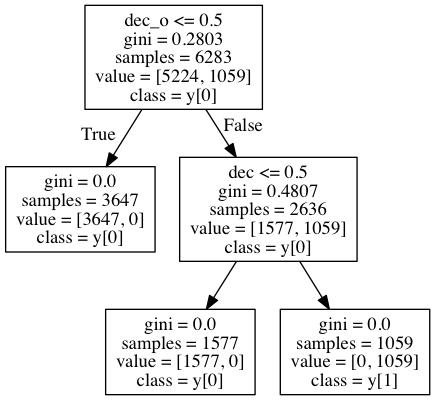

1.0

In [32]:
copy_df = deepcopy(df)
copy_df.fillna(0, inplace=True)

copy_df_X = copy_df.drop('match', axis=1)
copy_df_y = copy_df['match']

X, y = np.array(copy_df_X), np.array(copy_df_y)
dt_with_sklearn(*train_test_split(X, y),
                visualize=True, feature_names=copy_df_X.columns)

The accuracy of using decision tree with all the features to predict will be 1.  
After visualizing it, we found that `match` can be directly decided by `dec` and `dec_o` as the following rule.

|dec|dec_o|match|
|---|---|---|
|1|1|1|
|1|0|0|
|0|1|0|
|0|0|0|

In other word, only when both `dec` and `dec_o` are true, will `match` be true, which is reasonable.

Thus, `dec` and `dec_o` would be redundant when `match` is used as predict target.
  
  
  
---

However, when we were predicting `match`, we found that even simply using a single feature to predict could achieve the accuracy rate at around 82%.

In [33]:
copy_df['match'].value_counts()

0    6998
1    1380
Name: match, dtype: int64

Accroding to the ratio above, if our model always guesses 0, we can get accuracy at around 83.528%.  
We found that KNN or Decision Tree might not do well on skew data.  

In [34]:
copy_df['dec'].value_counts()

0    4860
1    3518
Name: dec, dtype: int64

In [35]:
copy_df['dec_o'].value_counts()

0    4863
1    3515
Name: dec_o, dtype: int64

On the other hand, using `dec` and `dec_o` would not encounter such problem.  
Since the data are mostly about the partipant, we decided to use `dec` as predict target and regard `match` as redundant feature.


---

# <a name='trainmethod'></a> Other Training Methods Implementation

### Split Data

In [36]:
LABELS = 'dec'
REDUDANT_COLUMNS = 'match'


def split_df(df, default_na=0, test_size=0.33, random_state=1):
    df = df.fillna(default_na).drop(REDUDANT_COLUMNS, axis=1)
    
    df_X = df.drop(LABELS, axis=1)
    df_y = df[LABELS]
    
    X, y = np.array(df_X), np.array(df_y)
    return train_test_split(X, y,
                            test_size=test_size, random_state=random_state)    

### Training with All Methods

In [37]:
def train_with_all_methods(df, verbose=True, **conf):
    split_args = conf.get('split_args', dict())
    knn_args = conf.get('knn_args', dict())
    dt_args = conf.get('dt_args', dict())
    
    data = split_df(df, **split_args)
    t1 = time.clock()
    sklearn_knn_acc = knn_with_sklearn(*data, **knn_args)
    t2 = time.clock()
    sklearn_dt_acc = dt_with_sklearn(*data, **dt_args)
    t3 = time.clock()
    self_knn_acc = knn(*data, *knn_args)
    t4 = time.clock()
    self_dt_acc = dt(*data, *dt_args)
    t5 = time.clock()
    
    if verbose:
        print('Sklearn KNN Accurary: ', sklearn_knn_acc," spends: ", t2-t1," s")
        print('Sklearn DT Accurary: ', sklearn_dt_acc," spends: ", t3-t2," s")
        print('KNN Accurary: ', self_knn_acc," spends: ", int((t4-t3) / 60 ), "min", (t4-t3) % 60, " s")
        print('DT Accurary: ', self_dt_acc," spends: ", t5-t4, " s")
    return np.array([sklearn_knn_acc, sklearn_dt_acc])

### Training with Different Split

In [38]:
def train_with_diff_split(df, verbose=True, conf=None, random_states=None, sample_num=1):
    if not random_states:
        random.seed(0)
        random_states = [random.random() for _ in range(sample_num)]
        
    if not conf:
        conf = dict()
    conf.setdefault('split_args', {'random_state': 0})
    
    all_accs = list()
    for i, s in enumerate(random_states, 1):
        if verbose:
            print('\n-----iter {}, random_state {}---'.format(i, s))
        conf['split_args']['random_state'] = s
        all_accs.append(train_with_all_methods(df, conf=conf))
    return np.average(all_accs, axis=0)

### Compare Accuracy

In [39]:
compare_acc = lambda acc1, acc2: acc1 - acc2

---

# <a name='feature-selction'></a> Feature Selection

## Baseline

In [40]:
baseline_df = deepcopy(df)

### Training

In [ ]:
baseline_acc = train_with_diff_split(baseline_df)
baseline_acc


-----iter 1, random_state 0.8444218515250481---


### Method to Compare Acuarcy with Baseline

In [42]:
compare_acc_with_baseline = partial(compare_acc, acc2=baseline_acc)

---

## Drop Columns or Rows with Too Many Null

In [43]:
df_drop_nan = deepcopy(df)

### Analysis

In [44]:
# Number of null value of each columns

cols_to_null_nums = df_drop_nan.isnull().sum(axis=0).sort_values(ascending=False)
cols_to_null_nums[:10]

num_in_3    7710
numdat_3    6882
expnum      6578
sinc7_2     6423
amb7_2      6423
shar7_2     6404
attr7_2     6394
fun7_2      6394
intel7_2    6394
attr5_3     6362
dtype: int64

In [45]:
# Number of null value of each row

rows_to_null_nums = df_drop_nan.isnull().sum(axis=1).sort_values(ascending=False)
rows_to_null_nums[:10]

839    168
842    168
843    168
845    168
847    168
838    167
324    155
841    151
840    150
844    150
dtype: int64

### Data Processing

In [46]:
# # Drop Rows

# ROW_THREASHOLD = 0

# df_drop_nan.dropna(axis=0, thresh=ROW_THREASHOLD, inplace=True);

In [47]:
# Drop Cols

COL_THREASHOLD = 1000

df_drop_nan.dropna(axis=1, thresh=COL_THREASHOLD, inplace=True)
print(len(df_drop_nan.columns))

192


### Training

In [76]:
drop_nan_acc = train_with_diff_split(df_drop_nan)
drop_nan_acc


-----iter 1, random_state 0.8444218515250481---


KeyboardInterrupt: 

### Compare

In [49]:
compare_acc_with_baseline(drop_nan_acc)

NameError: name 'drop_nan_acc' is not defined

---

## Hobby Similarity

In [ ]:
df_hs = deepcopy(df)

### Data Processing

In [ ]:
HOBBY_COLUMNS = [
    'sports', 'tvsports', 'exercise', 'dining', 'museums', 'art',
    'hiking', 'gaming', 'clubbing', 'reading', 'tv', 'theater',
    'movies', 'concerts', 'music', 'shopping', 'yoga'
]

similiar_thres = 1

In [ ]:
def count_hobby_similarity(joined_df,
                           similiar_thres=1,
                           na_default=-1):
    joined_df_no_na = joined_df.fillna(na_default)
    ss = list()
    for hobby in HOBBY_COLUMNS:
        temp_s = abs(joined_df_no_na[hobby+'_x'] - joined_df_no_na[hobby+'_y'])
        temp_s = (temp_s <= similiar_thres).astype(int)
        ss.append(temp_s)
    return sum(ss)

In [ ]:
df_hs['sim_hob_num'] = count_hobby_similarity(joined_df, similiar_thres=1)

In [ ]:
df_hs.drop(HOBBY_COLUMNS, axis=1, inplace=True)

### Training

In [ ]:
hs_acc = train_with_diff_split(df_hs)
hs_acc

### Compare

In [ ]:
compare_acc_with_baseline(hs_acc)

---

## Vectorize Category

- race, race_o
- go_out
- goal
- career_c

### Data Processing

In [ ]:
df_vc = deepcopy(baseline_df)

In [ ]:
def vectorize_column(df, col):
    v_df = pd.get_dummies(df[col], prefix=col)
    return df.drop(col, axis=1).join(v_df)

In [ ]:
category_cols = ['career_c', 'race', 'race_o', 'go_out', 'goal']

for col in category_cols:
    df_vc = vectorize_column(df_vc, col)

### Training

In [ ]:
vc_acc = train_with_diff_split(df_vc)
vc_acc

### Compare

In [ ]:
compare_acc_with_baseline(vc_acc)